In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
import os
import cv2
import DETR.util.misc as utils
from DETR.models import build_model
from DETR.modules.ExplanationGenerator import Generator

## Auxilary functions

In [2]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'klt', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'klt',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'interfering', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

#i only use 2 classes 
CLASSES = [
    'klt', 'interfering', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'klt',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'interfering', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


## Load the model

In [4]:
device = 'cuda'
args = Namespace(
    aux_loss = True,            
    backbone = 'resnet50',      
    batch_size = 4,             
    bbox_loss_coef = 5,         
    #clip_max_norm = 0.1,       
    coco_panoptic_path = None,  
    coco_path = None,           
    dataset_file = 'coco',      
    dec_layers = 6,             
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu',
    #dice_loss_coef = 1,        
    dilation = False,           
    dim_feedforward = 2048,     
    #dist_url = 'env://',       
    #distributed = False,       
    dropout = 0.0,              
    enc_layers = 6,             
    eos_coef = 0.1,             
    #epochs = 20,               
    #eval = False,              
    #frozen_weights = None,     
    giou_loss_coef = 2,         
    hidden_dim = 256,           
    lr = 0.5e-5,                
    lr_backbone = 1e-5,         
    #lr_drop = None,            
    #mask_loss_coef = 1,        
    masks = False,              
    nheads = 8,                 
    num_queries = 100,          
    #num_workers = 12,          
    #output_dir = '',           
    position_embedding = 'sine',
    pre_norm = False,           
    #remove_difficult = False,  
    resume = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
    #seed = 42,                 
    set_cost_bbox = 5,          
    set_cost_class = 1,         
    set_cost_giou = 2,          
    #start_epoch = 0,           
    weight_decay = 0.0001,      
    #world_size = 1             
)
model, criterion, postprocessors = build_model(args)
model.to(device)

checkpoint_name = "real_500_deterministic2"
checkpoint_path = f"DETR_checkpoints_paper/{checkpoint_name}.pth"

/home/dtr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dtr/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
checkpoint = torch.load(checkpoint_path, map_location='cpu')

transformations = [
    ('model.model.backbone', 'backbone'),
    ('conv_encoder', '0'),
    ('model.model', 'transformer'),
    ('encoder.layers.0.final_layer_norm', 'encoder.layers.0.norm2'),
    ('fc1', 'linear1'),
    ('fc2', 'linear2'),
    ('self_attn_layer_norm', 'norm1'),
    ('decoder.layers.0.final_layer_norm', 'decoder.layers.0.norm3'),
    ('encoder_attn_layer_norm', 'norm2'),
    ('encoder_attn', 'multihead_attn'),
    ('layernorm', 'norm'),
    ('transformer.query_position_embeddings.weight', 'query_embed.weight'),
    ('transformer.input_projection', 'input_proj'),
    ('model.bbox_predictor', 'bbox_embed'),
    ('model.class_labels_classifier', 'class_embed'),
    ('backbone.0.model','backbone.0.body'),
    ('transformer.encoder.layers.1.final_layer_norm','transformer.encoder.layers.1.norm2'),
    ('transformer.encoder.layers.2.final_layer_norm','transformer.encoder.layers.2.norm2'),
    ('transformer.encoder.layers.3.final_layer_norm','transformer.encoder.layers.3.norm2'),
    ('transformer.encoder.layers.4.final_layer_norm','transformer.encoder.layers.4.norm2'),
    ('transformer.encoder.layers.5.final_layer_norm','transformer.encoder.layers.5.norm2'),
    ('transformer.decoder.layers.1.final_layer_norm','transformer.decoder.layers.1.norm3'),
    ('transformer.decoder.layers.2.final_layer_norm','transformer.decoder.layers.2.norm3'),
    ('transformer.decoder.layers.3.final_layer_norm','transformer.decoder.layers.3.norm3'),
    ('transformer.decoder.layers.4.final_layer_norm','transformer.decoder.layers.4.norm3'),
    ('transformer.decoder.layers.5.final_layer_norm','transformer.decoder.layers.5.norm3')
]

def transform_key(k):
    for old, new in transformations:
        k = k.replace(old, new)
    return k

new_checkpoint = {transform_key(k): v for k, v in checkpoint.items()}

print(new_checkpoint.keys())


dict_keys(['backbone.0.body.conv1.weight', 'backbone.0.body.bn1.weight', 'backbone.0.body.bn1.bias', 'backbone.0.body.bn1.running_mean', 'backbone.0.body.bn1.running_var', 'backbone.0.body.layer1.0.conv1.weight', 'backbone.0.body.layer1.0.bn1.weight', 'backbone.0.body.layer1.0.bn1.bias', 'backbone.0.body.layer1.0.bn1.running_mean', 'backbone.0.body.layer1.0.bn1.running_var', 'backbone.0.body.layer1.0.conv2.weight', 'backbone.0.body.layer1.0.bn2.weight', 'backbone.0.body.layer1.0.bn2.bias', 'backbone.0.body.layer1.0.bn2.running_mean', 'backbone.0.body.layer1.0.bn2.running_var', 'backbone.0.body.layer1.0.conv3.weight', 'backbone.0.body.layer1.0.bn3.weight', 'backbone.0.body.layer1.0.bn3.bias', 'backbone.0.body.layer1.0.bn3.running_mean', 'backbone.0.body.layer1.0.bn3.running_var', 'backbone.0.body.layer1.0.downsample.0.weight', 'backbone.0.body.layer1.0.downsample.1.weight', 'backbone.0.body.layer1.0.downsample.1.bias', 'backbone.0.body.layer1.0.downsample.1.running_mean', 'backbone.0.bo

/tmp/ipykernel_748178/2551608796.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


In [6]:

def load_and_transform_checkpoint(old_checkpoint):
    transformed_checkpoint = {}

    num_layers_encoder = 6
    num_layers_decoder = 6

    for i in range(num_layers_encoder):
        base_key = f'transformer.encoder.layers.{i}.self_attn'
        combined_in_proj_weight = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.weight'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.weight'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.weight')   # V
        ], dim=0)
        combined_in_proj_bias = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.bias'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.bias'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.bias')   # V
        ])
        transformed_checkpoint[f'{base_key}.in_proj_weight'] = combined_in_proj_weight
        transformed_checkpoint[f'{base_key}.in_proj_bias'] = combined_in_proj_bias

    for i in range(num_layers_decoder):
        base_key = f'transformer.decoder.layers.{i}.self_attn'
        combined_in_proj_weight = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.weight'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.weight'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.weight')   # V
        ], dim=0)
        combined_in_proj_bias = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.bias'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.bias'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.bias')   # V
        ])
        transformed_checkpoint[f'{base_key}.in_proj_weight'] = combined_in_proj_weight
        transformed_checkpoint[f'{base_key}.in_proj_bias'] = combined_in_proj_bias

    for i in range(num_layers_decoder):
        base_key = f'transformer.decoder.layers.{i}.multihead_attn'
        combined_in_proj_weight = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.weight'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.weight'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.weight')   # V
        ], dim=0)
        combined_in_proj_bias = torch.cat([
            old_checkpoint.pop(f'{base_key}.q_proj.bias'),  # Q
            old_checkpoint.pop(f'{base_key}.k_proj.bias'),  # K
            old_checkpoint.pop(f'{base_key}.v_proj.bias')   # V
        ])
        transformed_checkpoint[f'{base_key}.in_proj_weight'] = combined_in_proj_weight
        transformed_checkpoint[f'{base_key}.in_proj_bias'] = combined_in_proj_bias

    transformed_checkpoint.update(old_checkpoint)

    return transformed_checkpoint

In [7]:
transformed_checkpoint = load_and_transform_checkpoint(new_checkpoint)
print(transformed_checkpoint.keys())

dict_keys(['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in_proj_weight', 'transformer.decoder.layers.1.self_attn.in_proj_bias', 'transformer.decoder.layers.2.self_attn.in_proj_weight', 'transformer.decoder.layers.2.self_a

In [8]:
model.load_state_dict(transformed_checkpoint, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.0.multihead_attn.in_proj_weight', 'transformer.decoder.layers.0.multihead_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in

## Use the Transformer-MM-Explainability code and generate a mask to visualize the features

In [9]:
from matplotlib.colors import LinearSegmentedColormap
prediction = False
def evaluate(model, gen, im, device, image_id = None):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # propagate through the model
    outputs = model(img)

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8
    softmax = torch.nn.Softmax(dim=-1) 
    probabilities = softmax(probas)

    if keep.nonzero().shape[0] < 1:
        return
    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()
    keep = keep.to(outputs['pred_boxes'].device)
    print(keep.nonzero())
    
    keep_indices = keep.nonzero()  
    
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #     lambda self, input, output: enc_attn_weights.append(output[1])
        # ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)

    model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[-1]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    img_np = np.array(im).astype(float)

    fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=3, figsize=(22, 7),squeeze=False)

    colors = ["yellow", "red"]
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)

    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        ax = ax_i[0]
        cam = gen.generate_ours(img, idx, use_lrp=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam_image = cam.view(h, w).data.cpu().numpy()

        # scale cam_image on the size of im
        h_im, w_im, _ = img_np.shape
        cam_scaled = cv2.resize(cam_image, (w_im, h_im), interpolation=cv2.INTER_LINEAR)
        ax.imshow(cam_image, cmap=plt.cm.Blues.reversed())
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')

        ax = ax_i[1]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((xmin.detach(), ymin.detach()), xmax.detach() - xmin.detach(), ymax.detach() - ymin.detach(),
                                fill=False, color='blue', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])

        ax = ax_i[2]
        ax.imshow(im)

        # define threshold and mask
        threshold = 0.1
        mask = cam_scaled > threshold

        # use the colour map for the scaled cam image wherre the mask is true
        rgba_image = np.zeros((h_im, w_im, 4))
        rgba_image[..., 0] = cmap(cam_scaled)[..., 0]  
        rgba_image[..., 1] = cmap(cam_scaled)[..., 1]  
        rgba_image[..., 3] = mask.astype(float)  # transparent if mask = false

        # visualize the mask
        ax.imshow(rgba_image, alpha=0.6)  
        ax.axis('off')
        ax.set_title("Visualizing the features")

    fig.tight_layout()
    plt.show()

## Paper examples

In [10]:
gen = Generator(model)

In [11]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')

In [12]:
url = 'http://images.cocodataset.org/val2017/000000216516.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')

In [13]:
url = 'http://images.cocodataset.org/val2017/000000359937.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')

In [14]:
url = 'http://images.cocodataset.org/val2017/000000192191.jpg'
im = Image.open(requests.get(url, stream=True).raw)

evaluate(model, gen, im, 'cuda')

## Adjusted the evaluate script for the visualization in the paper

In [15]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
prediction = False
train_visualization = False
def evaluate(model, gen, im, device, image_id = None):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # propagate through the model
    outputs = model(img)

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8
    softmax = torch.nn.Softmax(dim=-1) 
    probabilities = softmax(probas)

    if keep.nonzero().shape[0] < 1:
        return
    #prediction = True
    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()
    keep = keep.to(outputs['pred_boxes'].device)
    print(keep.nonzero())
    
    keep_indices = keep.nonzero()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #     lambda self, input, output: enc_attn_weights.append(output[1])
        # ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)

    model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[-1]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    img_np = np.array(im).astype(float)

    colors = ["#ffff00", "#ffa500", "#ff0000"]  # yellow → orange → red
    cmap = LinearSegmentedColormap.from_list("yellow_to_red", colors)

    for idx, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), bboxes_scaled):
        fig1, ax1 = plt.subplots(figsize=(20, 20))
        cam = gen.generate_ours(img, idx, use_lrp=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam_image = cam.view(h, w).data.cpu().numpy()

        # scale cam_image on the size of im
        h_im, w_im, _ = img_np.shape
        cam_scaled = cv2.resize(cam_image, (w_im, h_im), interpolation=cv2.INTER_LINEAR)
        ax1.imshow(cam_image, cmap=plt.cm.Blues.reversed())
        ax1.axis('off')
        im1 = ax1.imshow(cam_image, cmap=plt.cm.Blues.reversed())
        
        cbar = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, shrink=0.65)  # Add colorbar
        cbar.set_label('Relevance', fontsize=58)
        cbar.ax.tick_params(labelsize=50)
        plt.show()

        fig2, ax2 = plt.subplots(figsize=(20, 20))
        ax2.imshow(im)
        ax2.add_patch(plt.Rectangle((xmin.detach(), ymin.detach()), xmax.detach() - xmin.detach(), ymax.detach() - ymin.detach(),
                                fill=False, color='blue', linewidth=6))
        ax2.axis('off')
        #ax2.set_title(CLASSES[probas[idx].argmax()])
        plt.show()

        fig3, ax3 = plt.subplots(figsize=(20, 20))
        
        ax3.imshow(im)

        # define threshold and mask
        threshold = 0.4
        mask = cam_scaled > threshold

        # use the colour map for the scaled cam image where the mask is true
        rgba_image = cmap(cam_scaled)
        rgba_image[..., 3] = mask.astype(float)  # alpha channel

        rgba_image[..., 3] *= 0.6  # Apply global alpha factor
        ax3.imshow(rgba_image)
        ax3.axis('off')
        #ax3.set_title("Visualizing the features")
        norm = mcolors.Normalize(vmin=0.4, vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax3, fraction=0.046, pad=0.04, shrink=0.65)
        cbar.set_label('Relevance', fontsize=58)
        cbar.ax.tick_params(labelsize=50)

        if (train_visualization):
            if(checkpoint_name=="real_500_deterministic2"):
                fig3.savefig(f'DETR_paper_images/{checkpoint_name}/train_output.eps', format='eps', bbox_inches='tight')
                fig3.savefig(f'DETR_paper_images/{checkpoint_name}/train_output.png', bbox_inches='tight', dpi=300)
            elif((xmax-850)>0 and (xmax-850)<50 and (ymax-800)>0 and (ymax-800)<50 and (ymin-365)>0 and (ymin-365)<50):
                fig3.savefig(f'DETR_paper_images/{checkpoint_name}/train_output.eps', format='eps', bbox_inches='tight')
                fig3.savefig(f'DETR_paper_images/{checkpoint_name}/train_output.png', bbox_inches='tight', dpi=300)
        else:
            if((xmax-370)>0 and (xmax-370)<50 and (ymax-350)>0 and (ymax-350)<50 and (ymin-230)>0 and (ymin-230)<50):
                fig3.savefig(f'DETR_paper_images/{checkpoint_name}/output.eps', format='eps', bbox_inches='tight')
                fig3.savefig(f'DETR_paper_images/{checkpoint_name}/output.png', bbox_inches='tight', dpi=300)
            
        plt.show()

tensor([[61]])


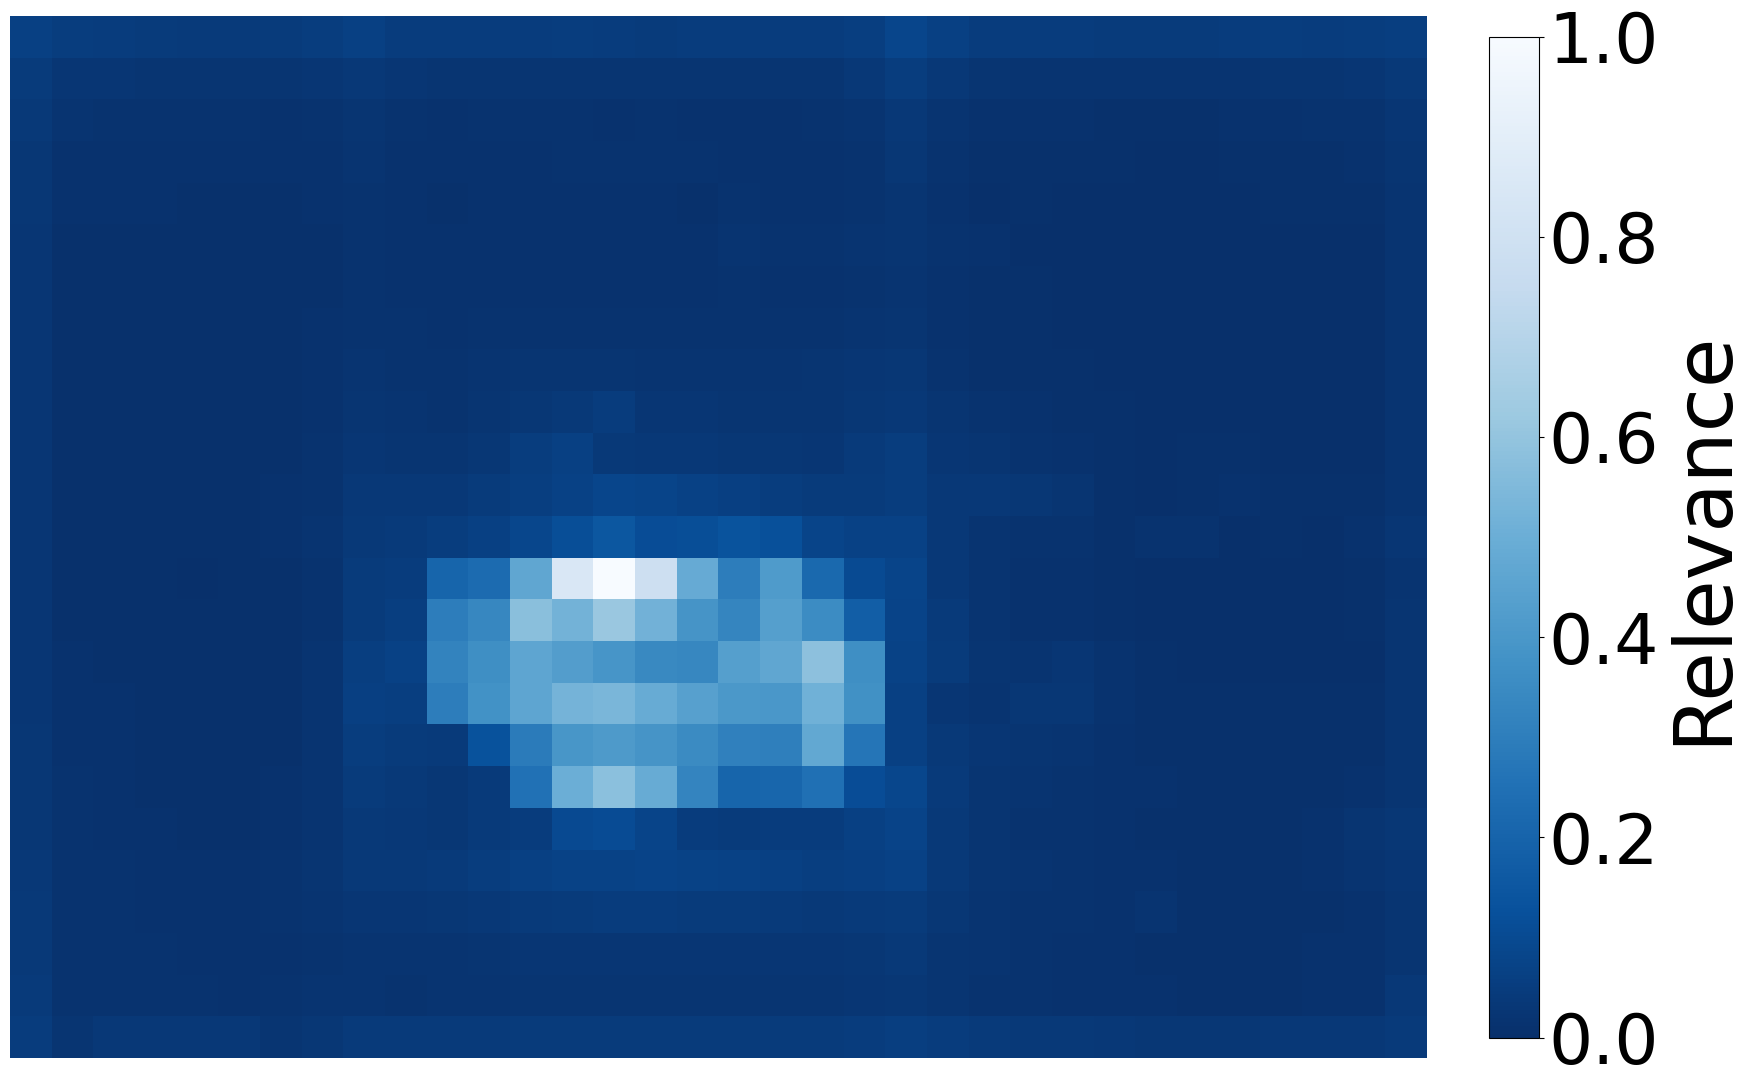

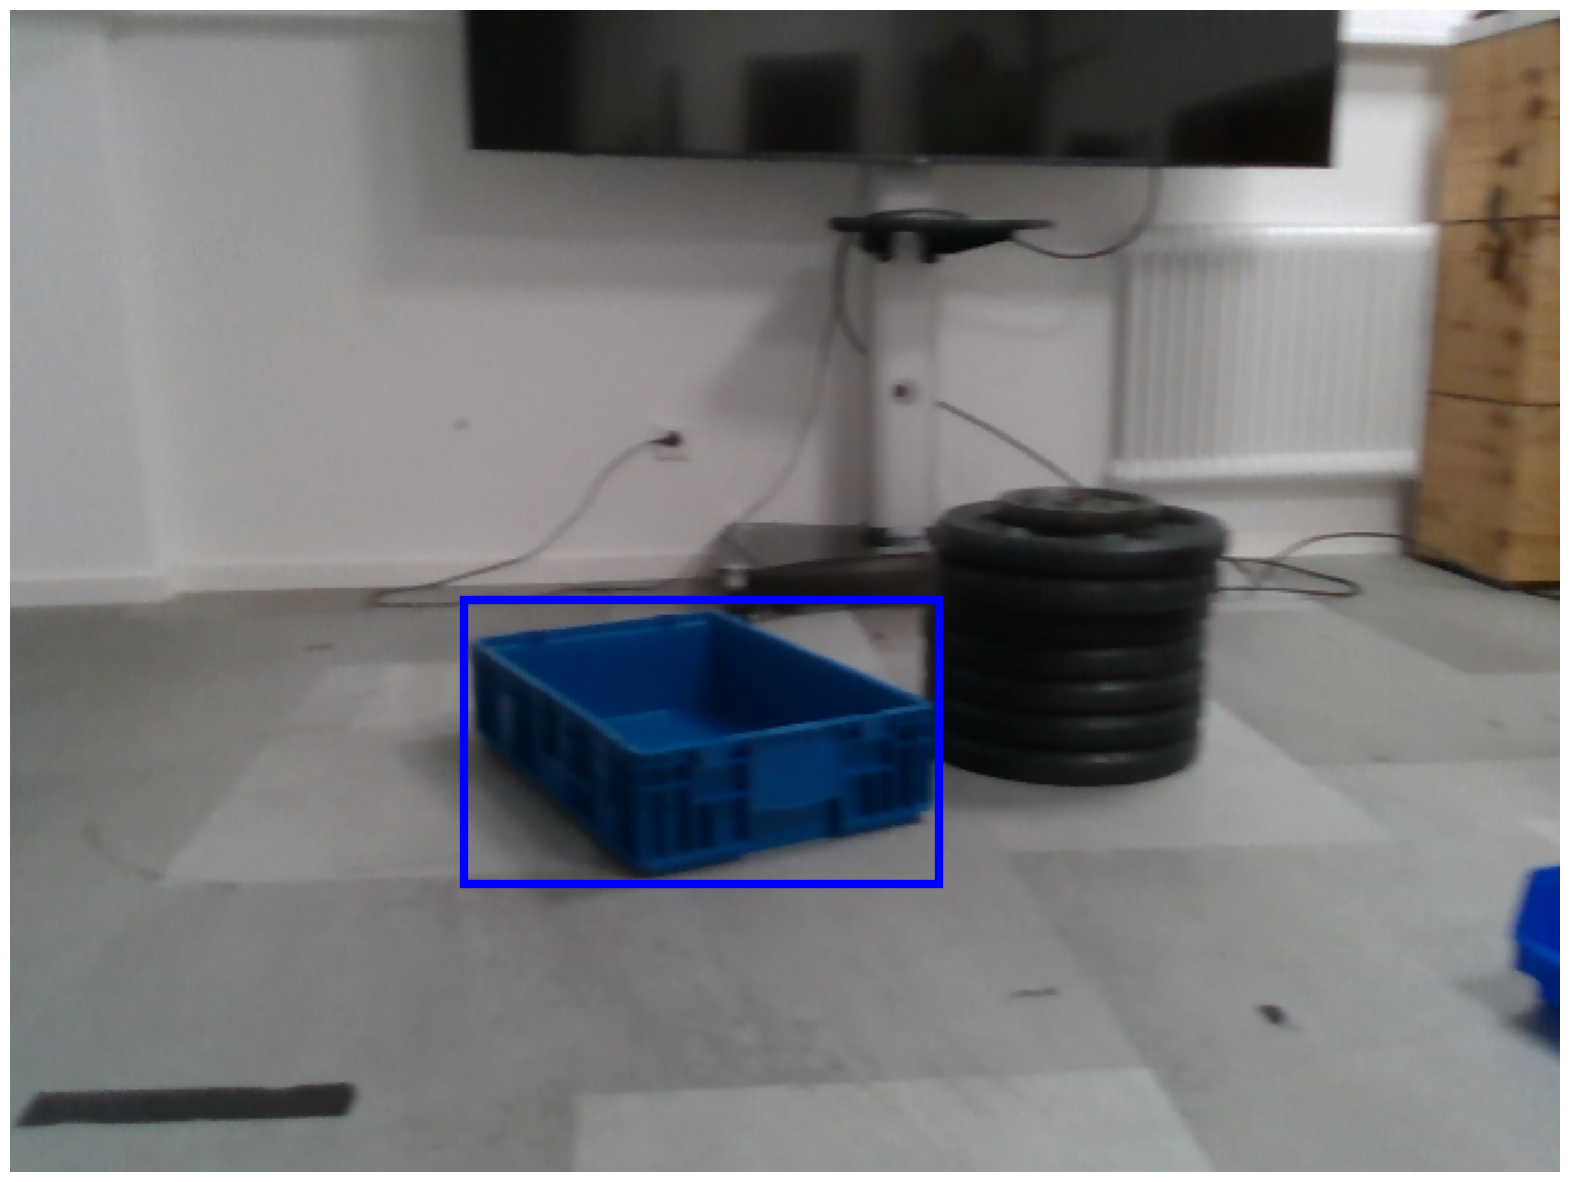

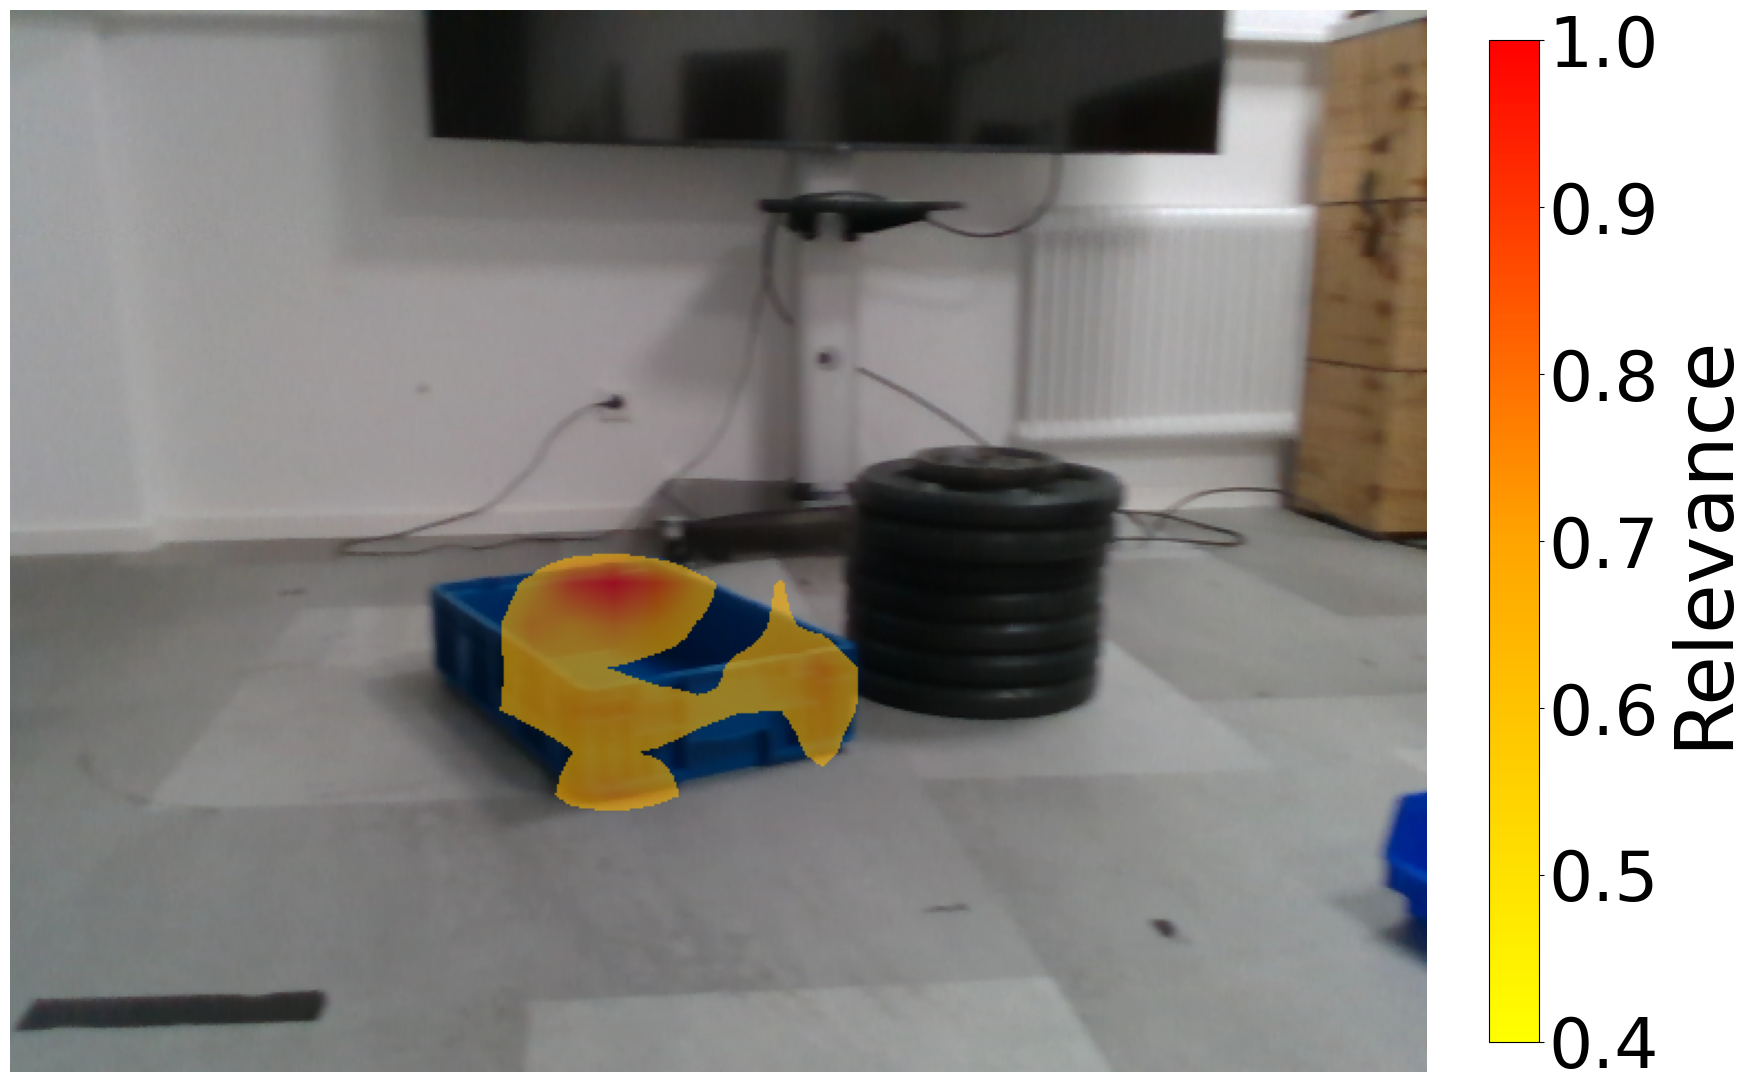

In [16]:
filename = "frame000251_rgb.png"
folder = 'test_video/'

if (train_visualization and checkpoint_name=="real_500_deterministic2"):
    filename = "000130.png"
    folder = 'datasets/Real/train'

if (train_visualization and checkpoint_name=="storage_box_labeled_deterministic2"):
    filename = "000001.png"
    folder = 'datasets/Storage Box/train'

if (train_visualization and checkpoint_name=="SD_V1_deterministic2"):
    filename = "000001.png"
    folder = 'datasets/SD-V1/train'

if (train_visualization and checkpoint_name=="SD_V2_deterministic2"):
    filename = "000001.png"
    folder = 'datasets/SD-V2/train'

filepath = os.path.join(folder, filename)
im = Image.open(filepath)

evaluate(model, gen, im, 'cuda')

# Vizualisation of the combinations

In [17]:
def detect_and_mask_red_areas(image, mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [18]:
from matplotlib.colors import LinearSegmentedColormap
from itertools import permutations
def evaluate(model, gen, im, device, image_id = None):
    img = transform(im).unsqueeze(0).to(device)
    outputs = model(img)

    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8    

    if keep.nonzero().shape[0] < 1:
        return
    
    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()
    keep = keep.to(outputs['pred_boxes'].device)
    print(keep.nonzero())
    
    keep_indices = keep.nonzero()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #     lambda self, input, output: enc_attn_weights.append(output[1])
        # ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)

    model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[-1]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    img_np = np.array(im).astype(float)

    for idx, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), bboxes_scaled):
        cam = gen.generate_ours(img, idx, use_lrp=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam_image = cam.view(h, w).data.cpu().numpy()

        # scale cam_image on the size of im
        h_im, w_im, _ = img_np.shape
        cam_scaled = cv2.resize(cam_image, (w_im, h_im), interpolation=cv2.INTER_LINEAR)

        # define threshold and mask
        threshold = 0.4
        mask = cam_scaled > threshold

        # use the colour map for the scaled cam image where the mask is true
        rgba_image = np.zeros((h_im, w_im, 4))
        rgba_image[..., 0] = 1 and mask.astype(float)
        rgba_image[..., 1] = 0
        rgba_image[..., 2] = 0
    
        contours = detect_and_mask_red_areas(rgba_image, mask)
        
        # print the position and size of the red areas
        for i, contour in enumerate(contours):
            x, y, w, h = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            print(f"Contour {i}: Position: ({x}, {y}), Size: ({w}, {h}), Area: {area}")

        img_np_uint8 = np.array(im).astype(np.uint8)       

        for perm_idx, perm in enumerate(permutations(contours)):
            fig, axs = plt.subplots(1, len(contours) + 1, figsize=(20, 10))
            
            axs[0].imshow(img_np_uint8)
            axs[0].set_title("Original Image")
            axs[0].axis('off')

            for i, contour in enumerate(perm):
                x, y, w, h = cv2.boundingRect(contour)
                area = cv2.contourArea(contour)
                img_np_uint8_copy = img_np_uint8.copy()
                # occlude the red area with green for visualization, in the paper we use black for the evaluation
                cv2.drawContours(img_np_uint8_copy, [contour], -1, (0, 255, 0), thickness=cv2.FILLED)

                # Visualization of the image with its mask
                axs[i + 1].imshow(img_np_uint8_copy)
                axs[i + 1].set_title(f"Masked Image {perm_idx + 1}, Step {i + 1}")
                axs[i + 1].axis('off')

            plt.tight_layout()
            plt.show()

tensor([[61]])
Contour 0: Position: (233, 353), Size: (8, 5), Area: 17.5
Contour 1: Position: (380, 311), Size: (30, 36), Area: 646.5
Contour 2: Position: (198, 267), Size: (101, 48), Area: 3319.0


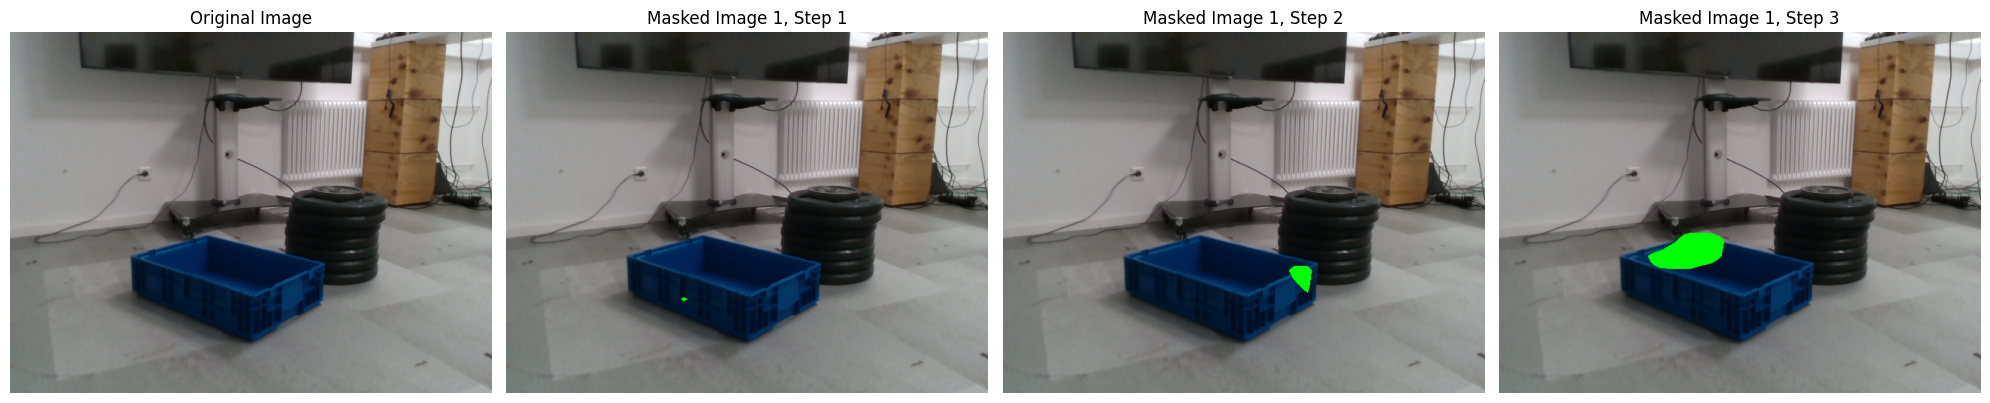

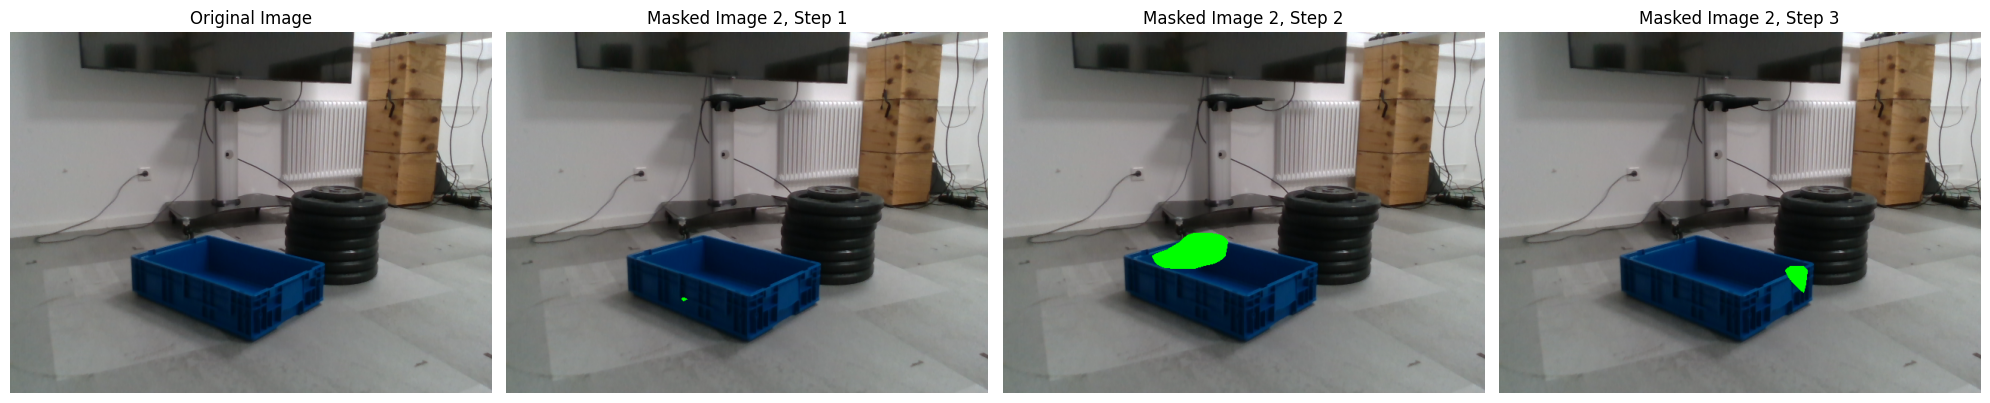

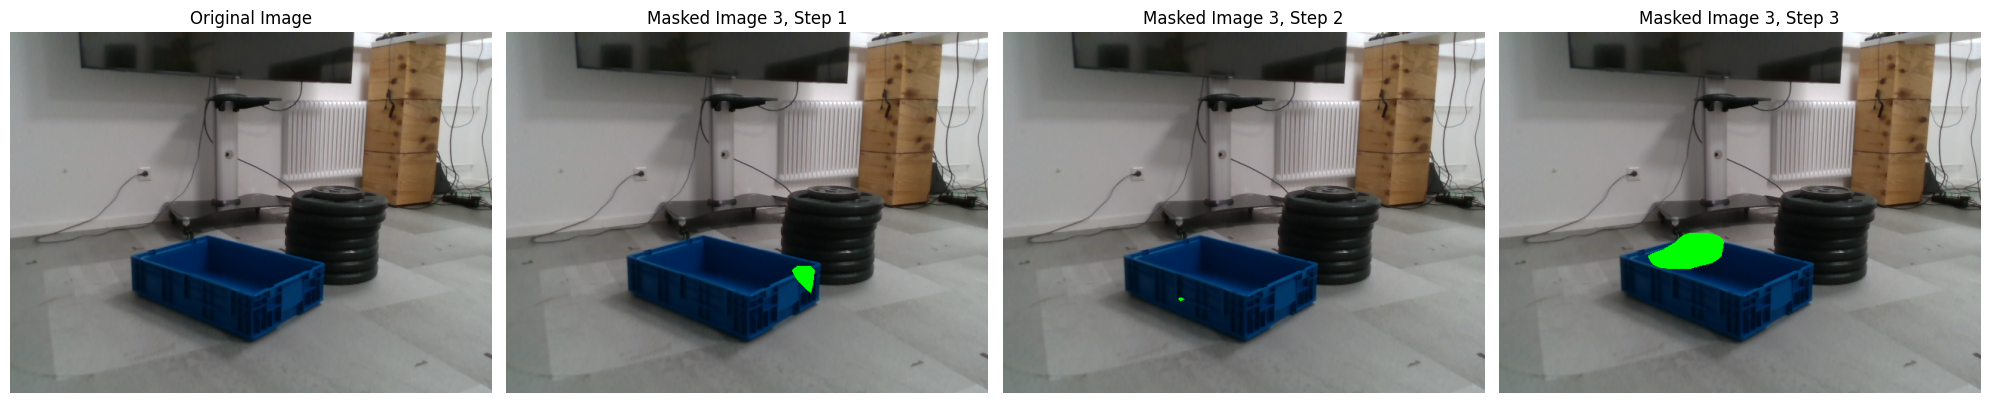

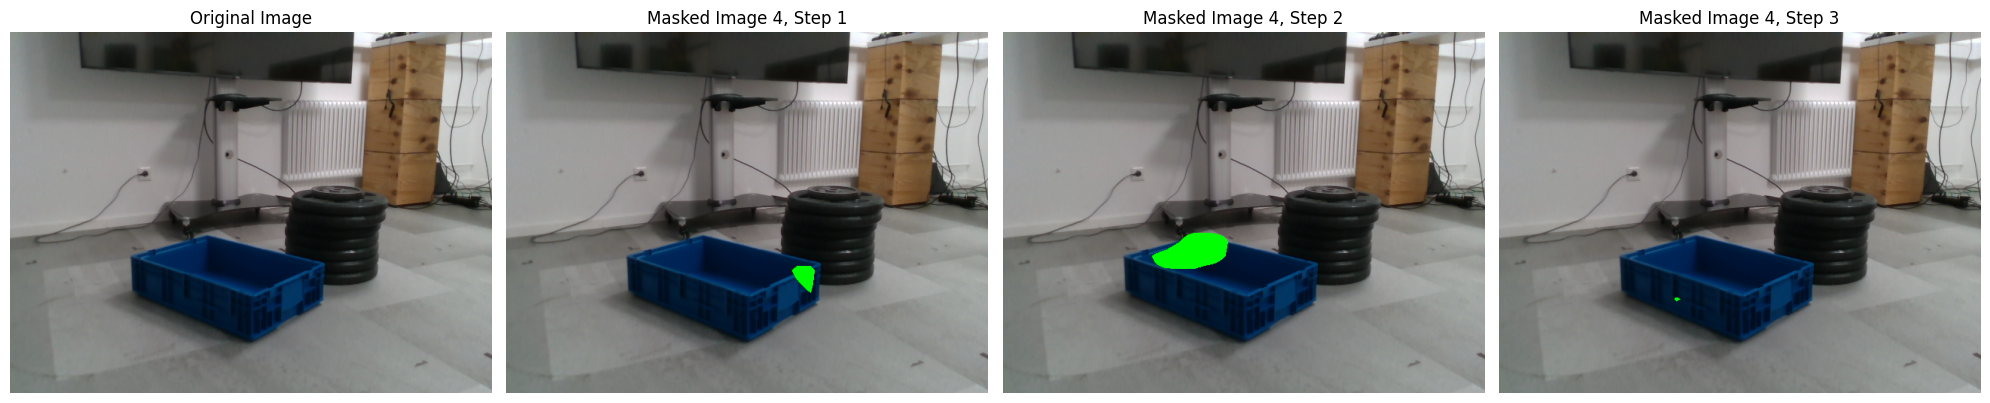

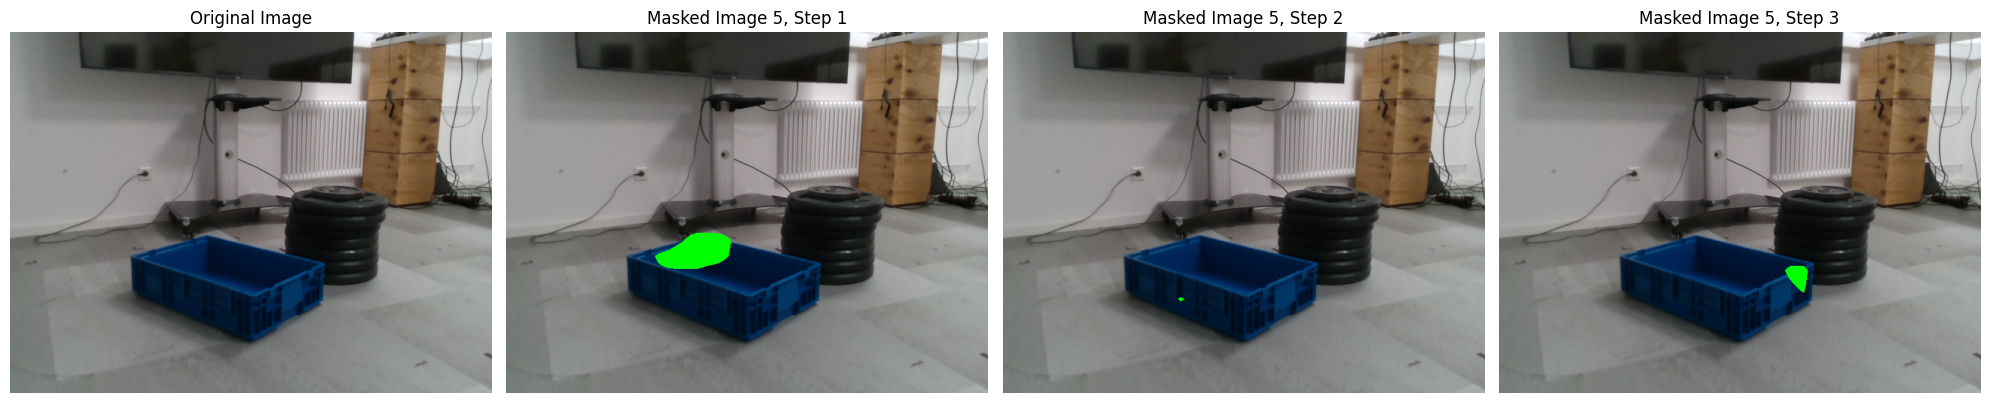

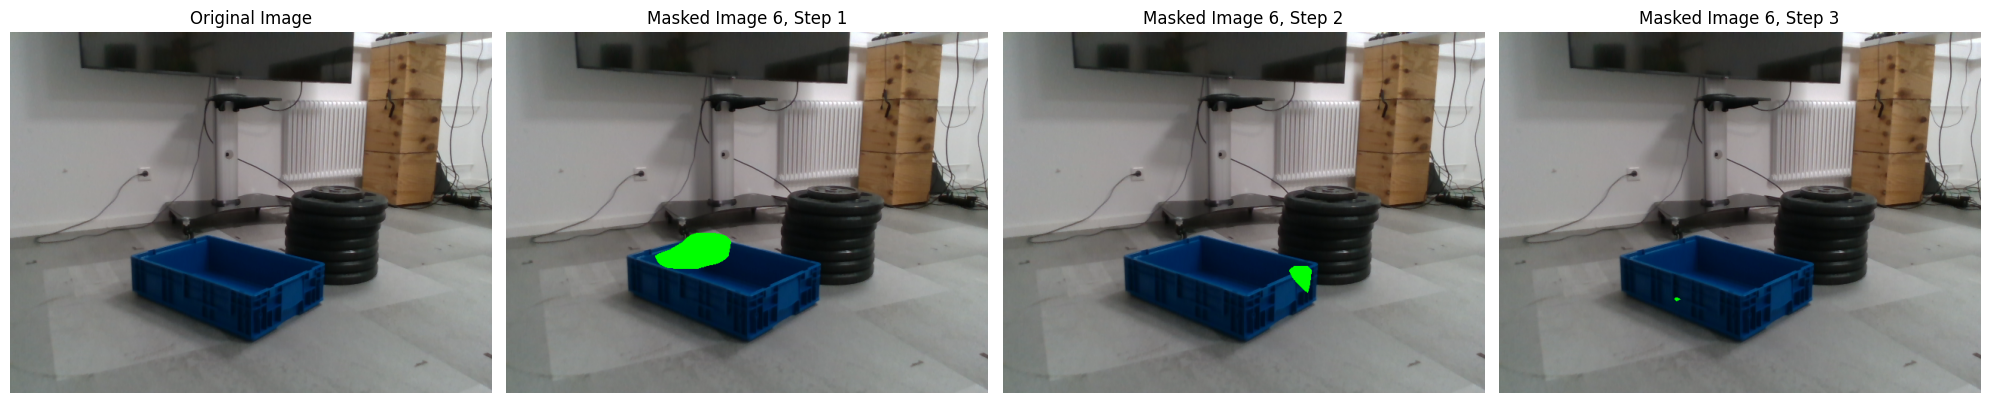

In [19]:
filename = "frame000462_rgb.png"
folder = 'test_video/'
filepath = os.path.join(folder, filename)
im = Image.open(filepath)

evaluate(model, gen, im, 'cuda')